The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images. - DONE
* Apply a distortion correction to raw images. - DONE
* Use color transforms, gradients, etc., to create a thresholded binary image. - DONE
* Apply a perspective transform to rectify binary image ("birds-eye view"). - DONE
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

In [1]:
# import useful libraries
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import glob
import time
import pickle

from sklearn.cross_validation import train_test_split
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from scipy.ndimage.measurements import label

from sklearn.metrics import recall_score,precision_score,f1_score

from PIL import Image
from moviepy.editor import VideoFileClip
from IPython.display import HTML

import os

# utilities libraries
import random

%matplotlib inline

/Users/davidwoo/anaconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
test_images = glob.glob(('test_images/*.jpg'))

print(test_images)

['test_images/sobel_test_lane_finding.jpg', 'test_images/straight_lines1.jpg', 'test_images/straight_lines2.jpg', 'test_images/test1.jpg', 'test_images/test2.jpg', 'test_images/test3.jpg', 'test_images/test4.jpg', 'test_images/test5.jpg', 'test_images/test6.jpg']


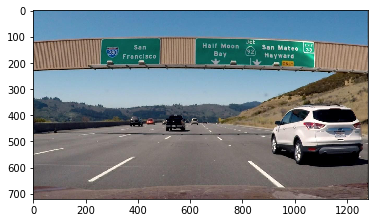

In [3]:

# Read in an image
image = mpimg.imread(test_images[0])
plt.imshow(image)


FUNCTIONS: Color and Gradient Thresholding

In [4]:
# Define a function that applies Sobel x or y, 
# then takes an absolute value and applies a threshold.
# Note: calling your function with orient='x', thresh_min=5, thresh_max=100
# should produce output like the example image shown above this quiz.
def abs_sobel_thresh(img, orient='x', thresh_min=0,sobel_kernel=3, thresh=(0, 255)):
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    grey = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    # 2) Take the derivative in x or y given orient = 'x' or 'y'
    if orient == 'x':
        sobel = cv2.Sobel(grey,cv2.CV_64F,1,0,ksize=sobel_kernel)
    else:
        sobel = cv2.Sobel(grey,cv2.CV_64F,0,1,ksize=sobel_kernel)
    # 3) Take the absolute value of the derivative or gradient
    abs_sobel = np.absolute(sobel)
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255 * abs_sobel / np.max(abs_sobel))
    print("range of abs sobel",np.min(scaled_sobel),np.max(scaled_sobel),np.median(scaled_sobel))
    # 5) Create a mask of 1's where the scaled gradient magnitude 
            # is > thresh_min and < thresh_max
    # return matrix with true or false
    # then do we merge the two?
    mask = (scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])
    print(mask.shape)
    binary_output = np.zeros_like(grey)
    binary_output[mask] = 1
    # 6) Return this mask as your binary_output image
    #binary_output = np.copy(img) # Remove this line
    return binary_output


# Define a function that applies Sobel x and y, 
# then computes the magnitude of the gradient
# and applies a threshold
def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    
    dimensions = ['x','y']
    sobel_dim = []
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    grey = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    for dim in dimensions:
        if dim == 'x':
            sobel = cv2.Sobel(grey,cv2.CV_64F,1,0,ksize=sobel_kernel)
        else:
            sobel = cv2.Sobel(grey,cv2.CV_64F,0,1,ksize=sobel_kernel)
        sobel_dim.append(sobel)
    # 3) Calculate the magnitude 
    mag_sobel = np.sqrt(np.add(sobel_dim[0]**2,sobel_dim[1]**2))
    # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scaled_sobel = np.uint8(255 * mag_sobel / np.max(mag_sobel))
    # 5) Create a binary mask where mag thresholds are met
    mask = (scaled_sobel >= mag_thresh[0]) & (scaled_sobel <= mag_thresh[1])
    binary_output = np.zeros_like(grey)
    binary_output[mask] = 1
    # 6) Return this mask as your binary_output image
    return binary_output

# Define a function that applies Sobel x and y, 
# then computes the direction of the gradient
# and applies a threshold.
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    
    dimensions = ['x','y']
    sobel_dim = []
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    grey = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    for dim in dimensions:
        if dim == 'x':
            sobel = cv2.Sobel(grey,cv2.CV_64F,1,0,ksize=sobel_kernel)
        else:
            sobel = cv2.Sobel(grey,cv2.CV_64F,0,1,ksize=sobel_kernel)
    # 3) Take the absolute value of the x and y gradients    
        abs_sobel = np.absolute(sobel)
        scaled_sobel = np.uint8(255 * abs_sobel / np.max(abs_sobel))
        #scaled_sobel = abs_sobel
        sobel_dim.append(scaled_sobel)
    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
    dir_sobel = np.arctan2(sobel_dim[1],sobel_dim[0])
    # 5) Create a binary mask where direction thresholds are met
    mask = (dir_sobel >= thresh[0]) & (dir_sobel <= thresh[1])
    binary_output = np.zeros_like(grey)
    binary_output[mask] = 1
    # 6) Return this mask as your binary_output image
    return binary_output

# next step use yuv color space. this seems pretty effective and then combine to apply naive method of lane finding

def color_space_threshold(image,thresh=(0, 255),color_space = 'HLS',color_channel = 2):
    
    # convert image to yuv space
    if color_space == 'HLS':
        cvt_image = cv2.cvtColor(image,cv2.COLOR_RGB2HLS)
        
    cvt_image = cvt_image[:,:,color_channel]
    # goal is to detect lanes or lines. then probably saturation is the best here.

    # play with threshold to see how to isolate lanes
    binary_mask = (cvt_image > thresh[0]) & (cvt_image <= thresh[1])
    binary_output = np.zeros_like(cvt_image)
    binary_output[binary_mask] = 1
    
    return binary_output


('range of abs sobel', 0, 255, 1.0)
(720, 1280)
('range of abs sobel', 0, 255, 2.0)
(720, 1280)


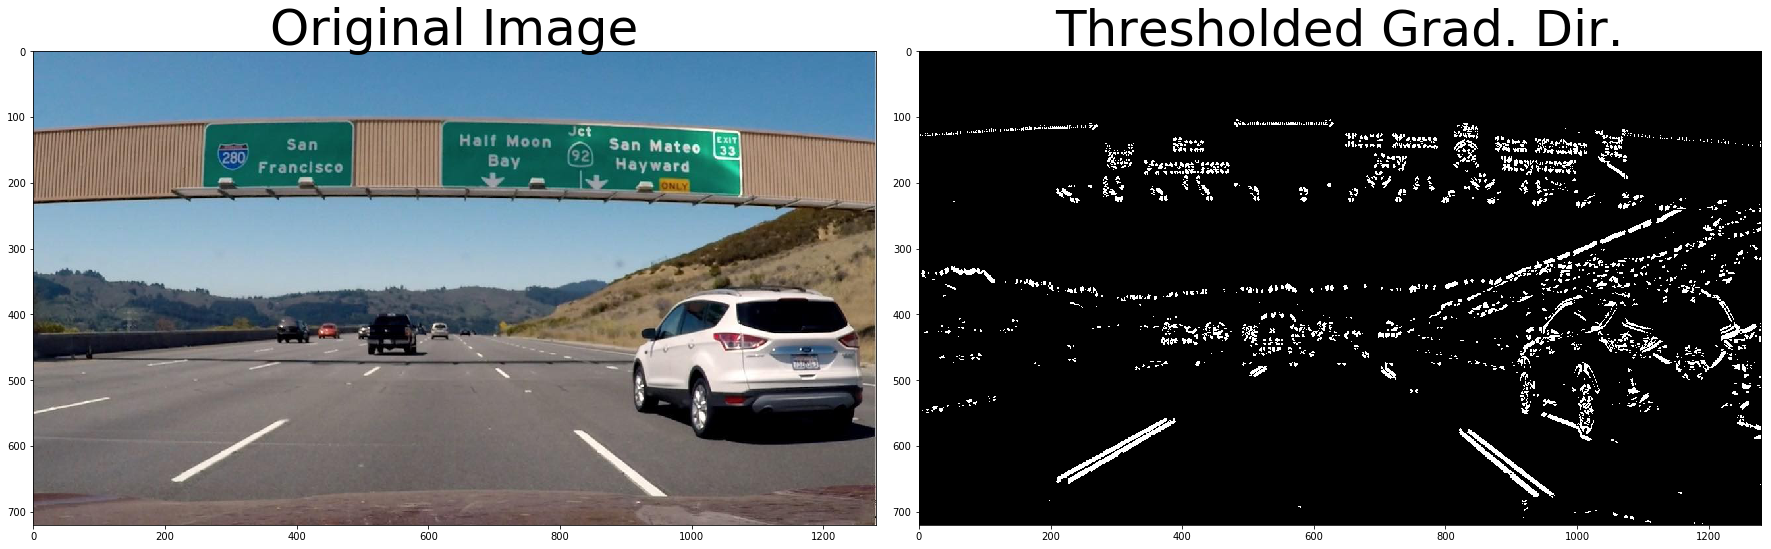

In [5]:
# Choose a Sobel kernel size
ksize = 15 # Choose a larger odd number to smooth gradient measurements

# Apply each of the thresholding functions
gradx = abs_sobel_thresh(image, orient='x', sobel_kernel=ksize, thresh=(20, 100))
grady = abs_sobel_thresh(image, orient='y', sobel_kernel=ksize, thresh=(20, 100))
mag_binary = mag_thresh(image, sobel_kernel=ksize, mag_thresh=(30, 200))
dir_binary = dir_threshold(image, sobel_kernel=ksize, thresh=(0.7, 1.3))

combined = np.zeros_like(dir_binary)
combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
#combined[((mag_binary == 1) & (dir_binary == 1))] = 1
#combined[(mag_binary == 1) ] = 1
#combined[(dir_binary == 1) ] = 1

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(combined, cmap='gray')
ax2.set_title('Thresholded Grad. Dir.', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [6]:
def plot_img_list (img_list,rows,list_type = 'images'):
    
    cols = int((len(img_list)) / rows)
    fig, axs = plt.subplots(rows,cols, figsize=(16,8 )) # this creates x subplots with each subplot with width and heigh
    axs = axs.ravel()

    for counter,img in enumerate(img_list):
        if list_type != 'images':
            img = mpimg.imread(img)
        axs[counter].imshow(img)


FUNCTIONS: Camera Calibration and Undistort Image

In [7]:
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
# Given board size of 9 blocks across and 6 blocks down

def get_chessboard_corners(exp_corners_x,exp_corners_y,img_file_list):

    # create zero array that stores x, y, z
    objpts = np.zeros((6*9,3), np.float32)
    objpts[:,:2]=np.mgrid[0:9,0:6].T.reshape(-1,2)

    # Arrays to store object points and image points from all the images.
    objpoints=[]# 3d points in real world space
    imgpoints=[] # 2d points in image plane.
    imges = []

    # Make a list of calibration images
    images = img_file_list 
    images.sort()

    # Step through the list and search for chessboard corners
    for img_file in images:

        img = mpimg.imread(img_file)
        grey = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
        # Find the chessboard corners
        retval,corners = cv2.findChessboardCorners(grey,(nx,ny),None)

        # If found, add object points, image points
        if retval:
            objpoints.append(objpts)
            imgpoints.append(corners)
            #print("corners found")
            # Draw and display the corners
            cv2.drawChessboardCorners(img,(nx,ny),corners,retval)
            imges.append(img)
        else:
            print("corners not found", img_file)
            
    return objpoints,imgpoints,imges

def undistort_img(objpoints,imgpoints,img_file_name):

    #load images
    img = mpimg.imread(img_file_name)
    grey = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    img_size = (img.shape[1],img.shape[0])

    # get camera matrix
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)

    # then get undistorted
    dst = cv2.undistort(img, mtx, dist,None,mtx)
    fig,(ax1,ax2) = plt.subplots(1,2,figsize=(20,10))
    ax1.imshow(img)
    ax1.set_title("original image")
    
    ax2.imshow(dst)
    ax2.set_title("undistorted image")
    
    return dst



1. Briefly state how you computed the camera matrix and distortion coefficients. Provide an example of a distortion corrected calibration image.

('corners not found', 'camera_cal/calibration1.jpg')
('corners not found', 'camera_cal/calibration4.jpg')
('corners not found', 'camera_cal/calibration5.jpg')


array([[[ 30,  26,  27],
        [ 30,  26,  27],
        [ 30,  26,  27],
        ..., 
        [234, 232, 233],
        [234, 232, 234],
        [234, 232, 235]],

       [[ 29,  25,  26],
        [ 29,  25,  26],
        [ 29,  25,  26],
        ..., 
        [233, 231, 233],
        [233, 231, 234],
        [233, 231, 234]],

       [[ 29,  25,  26],
        [ 29,  25,  26],
        [ 29,  25,  26],
        ..., 
        [233, 231, 233],
        [233, 231, 234],
        [232, 230, 233]],

       ..., 
       [[222, 220, 221],
        [221, 219, 220],
        [221, 219, 220],
        ..., 
        [ 13,  12,   8],
        [ 14,  13,   9],
        [ 14,  13,   9]],

       [[222, 220, 221],
        [221, 219, 221],
        [221, 219, 221],
        ..., 
        [ 14,  12,   9],
        [ 14,  13,  10],
        [ 14,  13,   9]],

       [[221, 219, 222],
        [222, 220, 223],
        [223, 221, 224],
        ..., 
        [ 14,  10,  11],
        [ 15,  11,  12],
        [ 13,  11,

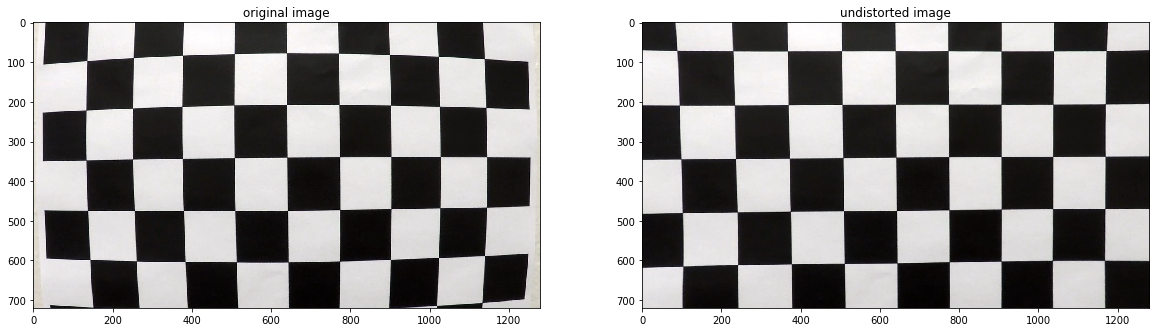

In [8]:
nx = 9
ny = 6

img_files = glob.glob('camera_cal/calibration*.jpg')

objpoints,imgpoints,imges = get_chessboard_corners(nx,ny,img_files)

#plt.imshow(imges[0])
#plot_img_list(imges,4)

undistort_img(objpoints,imgpoints,img_files[0])

* Apply a distortion correction to raw images.

['test_images/sobel_test_lane_finding.jpg', 'test_images/test1.jpg', 'test_images/test2.jpg', 'test_images/test3.jpg', 'test_images/test4.jpg', 'test_images/test5.jpg', 'test_images/test6.jpg']


array([[[ 91, 148, 186],
        [ 91, 148, 186],
        [ 90, 148, 186],
        ..., 
        [ 73, 131, 177],
        [ 73, 131, 177],
        [ 73, 131, 177]],

       [[ 94, 148, 187],
        [ 93, 148, 187],
        [ 93, 148, 187],
        ..., 
        [ 73, 131, 177],
        [ 72, 130, 176],
        [ 72, 130, 176]],

       [[ 95, 148, 188],
        [ 94, 148, 188],
        [ 94, 147, 187],
        ..., 
        [ 73, 130, 176],
        [ 73, 130, 176],
        [ 73, 130, 176]],

       ..., 
       [[106,  90, 100],
        [105,  89, 100],
        [106,  90, 100],
        ..., 
        [107,  87,  86],
        [107,  87,  86],
        [106,  86,  85]],

       [[109,  93, 103],
        [110,  94, 104],
        [110,  94, 104],
        ..., 
        [106,  86,  84],
        [106,  87,  85],
        [106,  86,  85]],

       [[114,  98, 108],
        [115,  99, 109],
        [115,  99, 109],
        ..., 
        [103,  84,  78],
        [105,  86,  80],
        [106,  87,

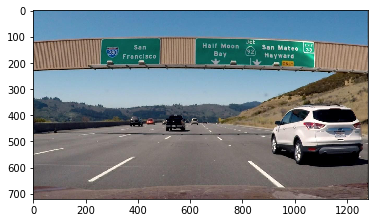

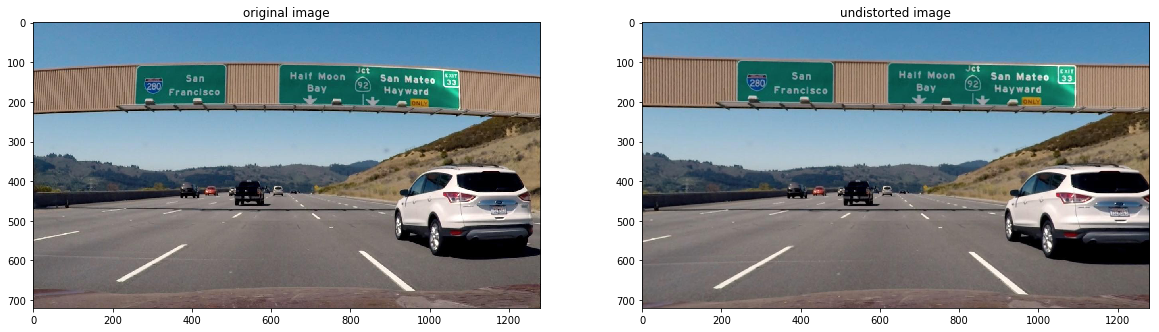

In [9]:
# First get 1 test images

test_images_files = glob.glob("test_images/**test*.jpg")
print(test_images_files)

image = mpimg.imread(test_images_files[0])
plt.imshow(image)

# can we measure the amount of distortion?
undistort_img(objpoints,imgpoints,test_images_files[0])


* Use color transforms, gradients, etc., to create a thresholded binary image.

('range of abs sobel', 0, 255, 1.0)
(720, 1280)
(0, 1)
('range of abs sobel', 0, 255, 1.0)
(720, 1280)


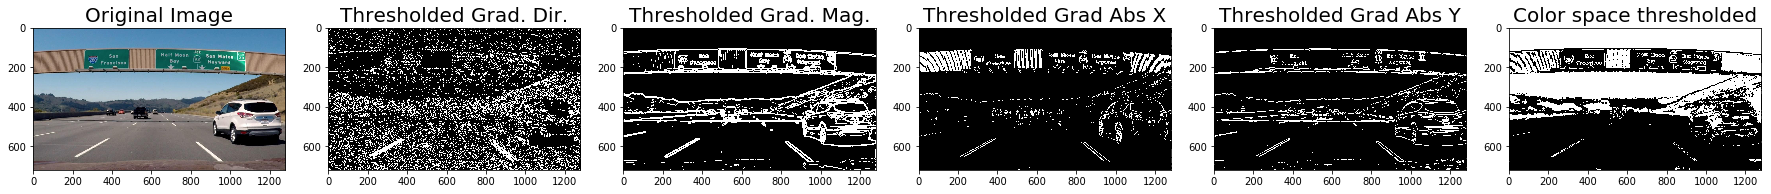

In [10]:
# Run the function
#radian, 0 deg = horizontal, 90 deg vertical. pi = 180, pi/2 = 90
#odd this seems to filter out vertical lines
dir_binary = dir_threshold(image, sobel_kernel=15, thresh=(0.7, 1.3))

#intuition behind magnitude?
mag_binary = mag_thresh(image, sobel_kernel=15, mag_thresh=(20, 255))

# 0 = black and 1 = white. white means a gradient is detected
# x does vertical lines
# basically, we want to weed out the black units. so the lower threshold is more important
abs_sobel_binary_x = abs_sobel_thresh(image, 'x', thresh_min=0,sobel_kernel=3, thresh=(20, 255))
print(np.min(abs_sobel_binary_x),np.max(abs_sobel_binary_x)) # range is too big then everything is 1
# y does horizontal lines
abs_sobel_binary_y = abs_sobel_thresh(image, 'y', thresh_min=0,sobel_kernel=3, thresh=(20, 255))

color_space_binary = color_space_threshold(image,thresh=(50, 150),color_space = 'HLS',color_channel = 2)

# Plot the result
font_size_val = 20
f, (ax1, ax2, ax3,ax4,ax5,ax6) = plt.subplots(1, 6, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=font_size_val)

ax2.imshow(dir_binary, cmap='gray')
ax2.set_title('Thresholded Grad. Dir.', fontsize=font_size_val)

ax3.imshow(mag_binary, cmap='gray')
ax3.set_title('Thresholded Grad. Mag.', fontsize=font_size_val)

ax4.imshow(abs_sobel_binary_x, cmap='gray')
ax4.set_title('Thresholded Grad Abs X', fontsize=font_size_val)

ax5.imshow(abs_sobel_binary_y, cmap='gray')
ax5.set_title('Thresholded Grad Abs Y', fontsize=font_size_val)

ax6.imshow(color_space_binary, cmap='gray')
ax6.set_title('Color space thresholded', fontsize=font_size_val)

plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

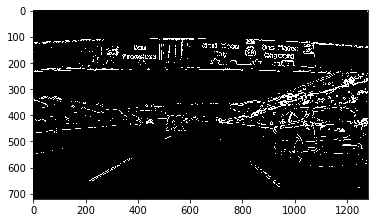

In [11]:
#combined thresholding

# all for now

combined_img = np.zeros_like(image[:,:,0])
#combined_mask = (dir_binary>0) & (mag_binary>0) & (abs_sobel_binary_x>0) & (abs_sobel_binary_y>0) &(color_space_binary>0)
#combined_mask = (mag_binary>0) & (abs_sobel_binary_x>0) & (color_space_binary>0)
combined_mask = (mag_binary>0) & (color_space_binary>0)
combined_img[combined_mask] = 1
#it's good but filter out alot here
plt.imshow(combined_img,cmap='gray')

#TODO
#1. Could we use math to find optimal? i.e highlight lane and non lane and max the number of pixesl
#2. Is there a way to loop through the number of combinations
#3. Optimize later. naive first

* Apply a perspective transform to rectify binary image ("birds-eye view").

In [12]:
# Choose to abstract source points, that way we can always use diff ways to get source
def get_birdeye_image_perspective(img,src,dst_offset):
    # 1. Add four corners of the lanes. i.e should form a trapezium
    img_size = (img.shape[1],img.shape[0])

    dst_offset = dst_offset

    # Order of corners is as follows
    ##### 1 ----- 2 #####
    ##### 4 ----- 3 #####

    #format x,y
    dst = np.float32([ [dst_offset,dst_offset],
                                    [img_size[0]-dst_offset,dst_offset],
                                    [img_size[0]-dst_offset,img_size[1]-dst_offset],
                                    [dst_offset,img_size[1]-dst_offset]
                                    ])

    x=np.hstack([src[:,0],src[0,0]])
    y=np.hstack([src[:,1],src[0,1]])

    ## plot original image with lane boundaries
    fig,(ax1,ax2)  = plt.subplots(1,2,figsize=(16,8))
    ax1.imshow(img)
    ax1.plot(x,y, color='#33cc99', alpha=0.4, linewidth=5, solid_capstyle='round', zorder=2)

    # 2. then apply perspective transform. given source and destination point
    ## a. Get transform matrix
    mtrix = cv2.getPerspectiveTransform(src,dst)
    ## b. Apply transform matrix
    trans_image = cv2.warpPerspective(img,mtrix,img_size)
    ax2.imshow(trans_image)
    
    return trans_image



First test for straight lines

['test_images/sobel_test_lane_finding.jpg', 'test_images/straight_lines1.jpg', 'test_images/straight_lines2.jpg', 'test_images/test1.jpg', 'test_images/test2.jpg', 'test_images/test3.jpg', 'test_images/test4.jpg', 'test_images/test5.jpg', 'test_images/test6.jpg']


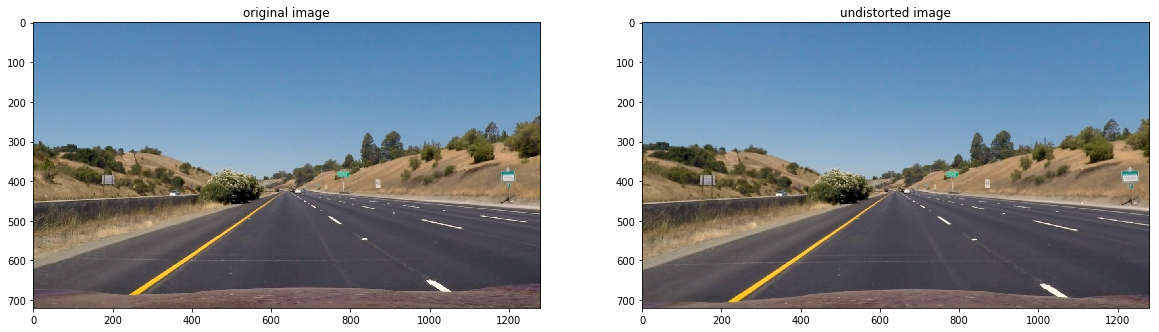

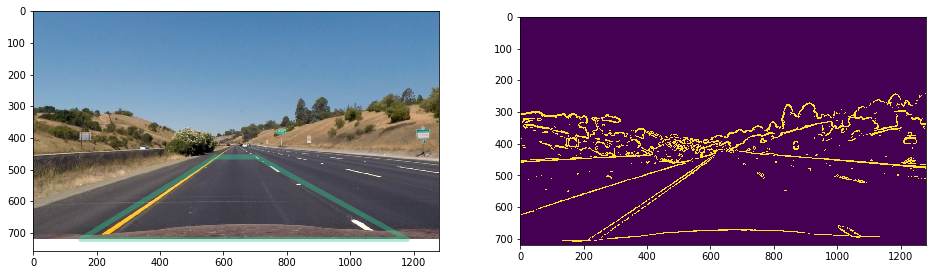

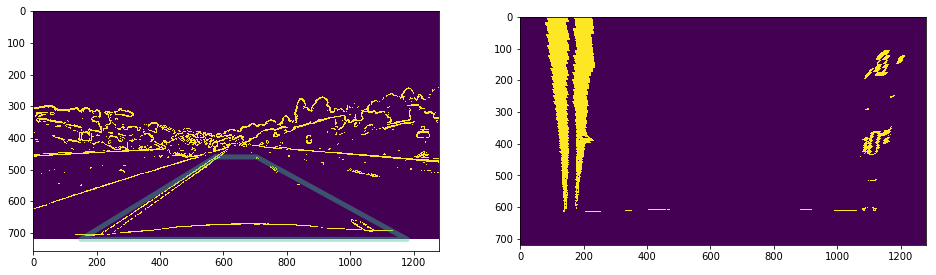

In [47]:
test_images_files = glob.glob("test_images/*.jpg")
print(test_images_files)

image = mpimg.imread(test_images_files[1])

image_undist = undistort_img(objpoints,imgpoints,test_images_files[1])
plt.imshow(image_undist)

image = image_undist

# choose to abstract this out. ideally we should get the lane start from the binary images
src_offset_x_btm_left = 150
src_offset_x_btm_right = 100
src_offset_x_top_left = 575
src_offset_x_top_right = 575
src_start_y = 460

dst_offset = 100

img_size = (image.shape[1],image.shape[0])

#format x,y
src = np.float32([ [src_offset_x_top_left,src_start_y],
                                [img_size[0]-src_offset_x_top_right,src_start_y],
                                [img_size[0]-src_offset_x_btm_right,img_size[1]],
                                [src_offset_x_btm_left,img_size[1]]
                                ])

trans_image = get_birdeye_image_perspective(image,src,dst_offset)

combined_img = np.zeros_like(image[:,:,0])
mag_binary = mag_thresh(image, sobel_kernel=15, mag_thresh=(50, 255))
color_space_binary = color_space_threshold(image,thresh=(10, 150),color_space = 'HLS',color_channel = 2)


combined_mask = (mag_binary>0) & (color_space_binary>0)
#combined_mask = (mag_binary>0) #& (color_space_binary>0)
combined_img[combined_mask] = 1
plt.imshow(combined_img)
trans_image = get_birdeye_image_perspective(combined_img,src,dst_offset)

Now test for curve lanes

['test_images/sobel_test_lane_finding.jpg', 'test_images/straight_lines1.jpg', 'test_images/straight_lines2.jpg', 'test_images/test1.jpg', 'test_images/test2.jpg', 'test_images/test3.jpg', 'test_images/test4.jpg', 'test_images/test5.jpg', 'test_images/test6.jpg']


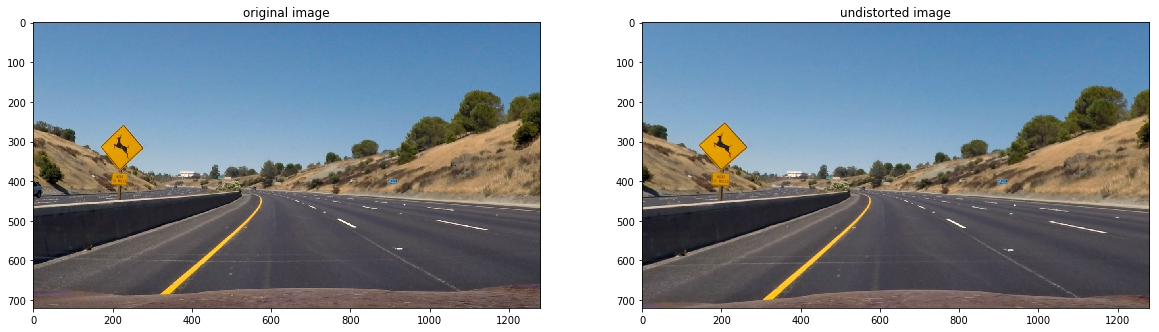

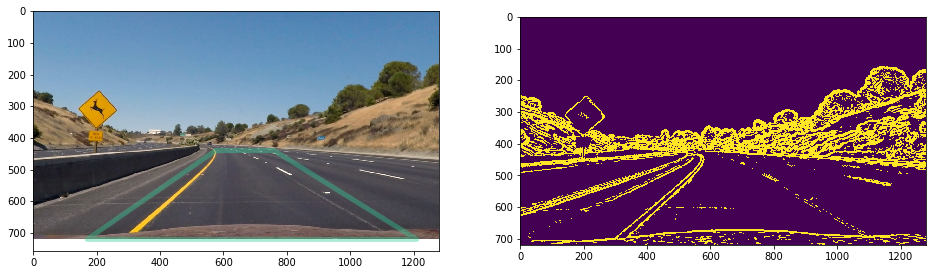

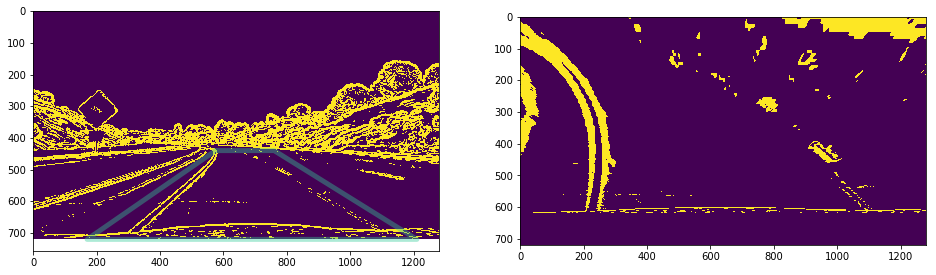

In [88]:
# nice it works. it's still somewhat parallel

test_images_files = glob.glob("test_images/*.jpg")
print(test_images_files)

image = mpimg.imread(test_images_files[4])

image_undist = undistort_img(objpoints,imgpoints,test_images_files[4])
plt.imshow(image_undist)

image = image_undist

# choose to abstract this out. ideally we should get the lane start from the binary images
src_offset_x_btm_left = 170
src_offset_x_btm_right = 70
src_offset_x_top_left = 575
src_offset_x_top_right = 520
src_start_y = 440

img_size = (image.shape[1],image.shape[0])

#format x,y
src = np.float32([ [src_offset_x_top_left,src_start_y],
                                [img_size[0]-src_offset_x_top_right,src_start_y],
                                [img_size[0]-src_offset_x_btm_right,img_size[1]],
                                [src_offset_x_btm_left,img_size[1]]
                                ])

trans_image = get_birdeye_image_perspective(image,src,dst_offset)


combined_img = np.zeros_like(image[:,:,0])
mag_binary = mag_thresh(image, sobel_kernel=15, mag_thresh=(20, 255))
color_space_binary = color_space_threshold(image,thresh=(10, 150),color_space = 'HLS',color_channel = 2)


combined_mask = (mag_binary>0) & (color_space_binary>0)
combined_img[combined_mask] = 1
plt.imshow(combined_img)
trans_image = get_birdeye_image_perspective(combined_img,src,dst_offset)
trans_image_orig = trans_image

* Detect lane pixels and fit to find the lane boundary.

In [ ]:
# Next steps
# 1. Naive implementation of sliding window. maybe more debate it first. why this is important and isnt there a another way
# 2. Then do naive implementation
# 3. Then more optimal implementation

# 4. Also, do perspective first then do binary image. Still feel not sure if sliding window is necessary.

#Useful projects and resources:
#https://chatbotslife.com/robust-lane-finding-using-advanced-computer-vision-techniques-46875bb3c8aa

('image shape', (720, 1280))
(218, 975)
('window height', 80)
('nonzero x', array([ 342,  343,  344, ..., 1171, 1172, 1173]))
('poly fit', array([ 0.00241001,  1.04419853,  1.19844206]), array([  9.38985999e-03,  -1.60199492e+01,   6.93066501e+03]))


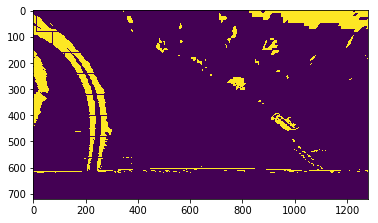

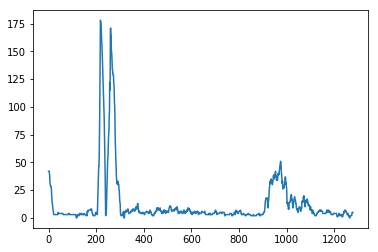

In [93]:
# Use this image as test image. ideally we should have two clear lane lines
trans_image = trans_image_orig

fig = plt.figure()
plt.imshow(trans_image)
print("image shape",trans_image.shape)

#Steps

##1. Get histogram of bottom half of image
# a) set bottom half of picture
y_start = 400

#fig = plt.figure()
#plt.imshow(trans_image[y_start:,:])

# b) next plot histogram, for each, x value, sum y value
hist = np.sum(trans_image[y_start:,:],axis=0)
fig = plt.figure()
plt.plot(hist)

##2. Get peaks
# a) get midpoint of histogram to seperate left and right
hist_midpt = hist.shape[0]/2
# b) get left lane and right lane start
left_lane_xbase = np.argmax(hist[:hist_midpt])
right_lane_xbase = np.argmax(hist[hist_midpt:])+hist_midpt
print(left_lane_xbase,right_lane_xbase)

##3. Chose number of sliding windows
nwindows = 9

##4. Set height of windows
window_height = trans_image.shape[0] / nwindows
print("window height",window_height)

##5. Identify the x and y positions of all nonzero pixels in the image
nonzero = trans_image.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
print("nonzero x",nonzerox)

##6 Set current positions. These will be updated for each window
#a) center positions
left_center_x = left_lane_xbase
right_center_x = right_lane_xbase

#b) window size
margin = 100

#c) min pixels
minpix = 50

#d) create empty list to store left and right lane pixels
left_lane_inds = []
right_lane_inds = []

##7 Step through windows one by one

for window in range(nwindows):
    
    #a) calculate window coordinates for left and right lane
    win_y_bottom = trans_image.shape[0] - (window+1)*window_height
    win_y_top = trans_image.shape[0] - window*window_height
    
    #b)left lane
    left_window_x_left_crner = left_center_x - margin
    left_window_x_right_crner = left_center_x + margin
    
    #c)right lane
    right_window_x_left_crner = right_center_x - margin
    right_window_x_right_crner = right_center_x + margin
    
    #d)draw window coordinates
    
    #left lane
    top_left = (left_window_x_left_crner,win_y_top)
    bottom_right = (left_window_x_right_crner,win_y_bottom)
    cv2.rectangle(trans_image,top_left,bottom_right,(0,255,0), 2)
    
    #right lane
    top_left = (left_window_x_left_crner,win_y_top)
    bottom_right = (left_window_x_right_crner,win_y_bottom)
    cv2.rectangle(trans_image,top_left,bottom_right,(0,255,0), 2)
    
    #e) identify the nonzero pixels within the window
    # y : get non zero between bottom and top of y axis
    # x : get non zero between bottom and top of y axis
    
    # both x and y needs to meet the conditions
    good_left = ((nonzeroy < win_y_top) & (nonzeroy >= win_y_bottom) & (nonzerox <= left_window_x_right_crner) & (nonzerox >= left_window_x_left_crner)).nonzero()[0]
    good_right = ((nonzeroy < win_y_top) & (nonzeroy >= win_y_bottom) & (nonzerox <= right_window_x_right_crner) & (nonzerox >= right_window_x_left_crner)).nonzero()[0]
    
    left_lane_inds.append(good_left)
    right_lane_inds.append(good_right)
    
    #f) recenter windows of found pixels more than threshold
    
    if len(good_left) > minpix:
        #print("num left pixels",len(good_left),nonzerox[good_left])
        #print("total x pixels",len(nonzerox))
        # get indices of nonzero x, then get mean
        left_center_x = np.int(np.mean(nonzerox[good_left]))
    
    if len(good_right) > minpix:
        right_center_x = np.int(np.mean(nonzerox[good_right]))

# 8 Concatenate the array of indices. This will get indices of all non zero pixel
left_lane_inds = np.concatenate(left_lane_inds)
right_lane_inds = np.concatenate(right_lane_inds)

# 9 Extract left and right line pixel positions
left_lane_x = nonzerox[left_lane_inds]
left_lane_y = nonzeroy[left_lane_inds]

right_lane_x = nonzerox[right_lane_inds]
right_lane_y = nonzeroy[right_lane_inds]

left_fit = np.polyfit(left_lane_x,left_lane_y,2)
right_fit = np.polyfit(right_lane_x,right_lane_y,2)

print("poly fit",left_fit,right_fit)

In [ ]:
# nice great achievement. able to do sliding windows

# next step
# a) fix plot, want to be able to see the boxes being drawn
# b) then see equation of the line
# c) then measure curvature

In [55]:
test = np.array([[1,2,3]])
test

# return the indices of the largest value
np.argmax(test)

2